In [1]:
# # Import the necessary libraries
import tensorflow as tf
import numpy as np
import cv2
import time
import os
import matplotlib.pyplot as plt
from PIL import Image

In [41]:
# Specify necessary paths
configPath = r'bccd.cfg'
weightsPath = r'yolov4.bccd.best.weights'
labelsPath = r'prep_data _yolo_v4\train\_darknet.labels'

In [42]:
# Preparing labels from file
LABELS = open(labelsPath).read().strip().split("\n")

In [43]:
# Initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
    dtype="uint8")

In [44]:
# Read the cnfg and weights of model
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

In [60]:
# Specify image path
img_path = r"prep_data _yolo_v4\test\tank_t72b3.jpg"

# Function for open and convert images into np array
def load_image(img_path):
    img = Image.open(img_path)
    img.load()
    data = np.asarray( img, dtype="float32" )
    return data

image  = load_image(img_path)
# Height and width of image
(H, W) = image.shape[:2]
image.shape

(592, 966, 3)

In [61]:
# Determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [62]:
# Construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
    swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
# Show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 2.252129 seconds


In [63]:
# Initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

#Minimum probability to filter weak detections
tresh_conf = 0.3

# This is our non-maxima suppression threshold.Default value is 0.3
non_max_supp_conf = 0.1

In [65]:
# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        # Extract the class ID and confidence (i.e., probability) of
        # the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        # Filter out weak predictions by ensuring the detected
        # Probability is greater than the minimum probability
        if confidence > tresh_conf:
            # Scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")
            # uUe the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            # Update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

In [66]:
# Apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, tresh_conf,
                        non_max_supp_conf)

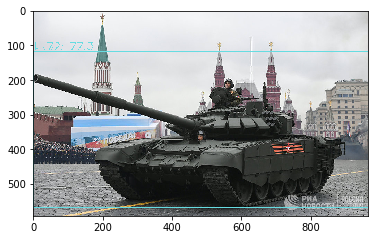

In [73]:
text_thick = 1 # text thickness
rect_thick = 2 # rectangle thickness
font_face = cv2.FONT_HERSHEY_SIMPLEX # font type
fontScale = 1

# Ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # Extract the bounding box coordinates
        (x, y) = (boxes[i][0] if boxes[i][0]>=rect_thick else boxes[i][0]-boxes[i][0]+rect_thick, 
                  boxes[i][1] if boxes[i][1]>=rect_thick else boxes[i][1]-boxes[i][1]+rect_thick)
     
        (w, h) = (boxes[i][2], boxes[i][3])
        # Draw a bounding box rectangle and label on the image
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, rect_thick)
        text = "{}: {:.1f}".format(LABELS[classIDs[i]], confidences[i]*100)
        y_text = y - 10 if y - 10 > 10 else y + 10
        x_text = x - 10 if x - 10 > 10 else x + 10
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
            fontScale, color, text_thick)
# Show the output image
plt.imshow(image.astype(np.uint8))
plt.show()
